In [33]:
import pandas as pd
import numpy as np
from lib import raw_ds_columns, calc_ts_diff
from visualization import display_point_process_events
from scipy.optimize import minimize
from tick.hawkes import HawkesSumExpKern, HawkesBasisKernels, HawkesKernelTimeFunc, SimuHawkes
import statsmodels
from scipy import integrate
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import statsmodels.api as sm
import itertools

plt.style.use('ggplot')

In [2]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot, row, column, grid
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [3]:
n_plus_ts = pd.read_csv("data/current_n_plus.csv", header=None)
n_plus_ts.set_index(0)

n_plus_ts.drop(n_plus_ts.columns[0], axis = 1, inplace=True)
n_plus_ts.columns = n_plus_ts.iloc[0]
n_plus_ts = n_plus_ts.iloc[1:]

n_plus_ts["Bid_time"] = n_plus_ts["Bid_time"].astype(int)
n_plus_ts["Mid_IV"] = n_plus_ts["Mid_IV"].astype(float)
n_plus_ts["Mid_price"] = n_plus_ts["Mid_price"].astype(float)


In [4]:
n_plus_ts

,Trade_date,Bid_time,Option_expiration,Call_Put,Price_strike,Bid_price,Bid_size,Ask_price,Ask_size,Mid_price,Underlying_mid_price,log_moneyness,Time_to_expiry,Mid_IV,Mid_price_diff,Bid_time_diff,Mid_IV_diff,Mid_price_ret,Mid_IV_diff_sign
1,10/21/2020,3131987,12/18/2020,C,3500.0,99.4,238,100.4,30,99.90,3441.9,-0.016739324004297996,0.1589041095890411,0.229872,0.20000000000000284,33.0,0.00022920395696865437,0.002004008686715262,1.0
2,10/21/2020,3382080,12/18/2020,P,3435.0,137.3,15,138.2,15,137.75,3445.5550000000003,0.003068068863502391,0.1589041095890411,0.261431,-1.0,1.0,0.01749495411912874,-0.007233304593520061,1.0
3,10/21/2020,3472675,12/18/2020,C,3435.0,138.3,60,139.1,45,138.70,3445.0,0.0029069787913093108,0.1589041095890411,0.244385,5.599999999999994,64945.0,0.001888807564377204,0.041212601919719975,1.0
4,10/21/2020,3472718,12/18/2020,P,3435.0,137.4,60,138.2,60,137.80,3445.0,0.0029069787913093108,0.1589041095890411,0.261047,-0.8999999999999773,43.0,0.016662413892453515,-0.006509968741227542,1.0
5,10/21/2020,3563397,12/18/2020,P,3435.0,137.3,15,138.0,15,137.65,3445.23,0.0029737399879848827,0.1589041095890411,0.260969,-0.44999999999998863,11845.0,8.958717220169943e-05,-0.0032638288266300694,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,10/21/2020,27132296,12/18/2020,P,3435.0,133.7,15,134.6,35,134.15,3445.51,0.003055008472982005,0.1589041095890411,0.254801,-1.150000000000034,26.0,0.017137281576914687,-0.008535958305109476,1.0
358,10/21/2020,27190743,12/18/2020,P,3440.0,136.3,15,137.2,15,136.75,3445.075,0.0014742035254849397,0.1589041095890411,0.254505,5.0,837.0,0.01837911922158153,0.03724825388061878,1.0
359,10/21/2020,27207733,12/18/2020,P,3440.0,136.8,15,137.7,15,137.25,3444.98,0.0014466275482234278,0.1589041095890411,0.255337,5.5,16451.0,0.01921133058583968,0.04089789296816831,1.0
360,10/21/2020,27236319,12/18/2020,P,3375.0,114.2,49,114.4,23,114.30,3444.84,0.020482134940651417,0.1589041095890411,0.270444,-22.94999999999999,28586.0,0.01510728158907415,-0.18297750958887493,1.0


In [5]:
display_point_process_events(n_plus_ts)

In [4]:
def get_learner(decays, verbose=False):
    return HawkesSumExpKern(decays, verbose=verbose, tol=1e-10, max_iter=1000)


def get_HP_exp_learner(decays, events, verbose=False):
    learner = get_learner(decays, verbose)
    learner.fit(events)
    if verbose:
        print("Adj: {}, decays: {}, baselines: {}".format(learner.adjacency, decays, learner.baseline))
    return learner


def fun(decays, events):
    return - HawkesSumExpKern(decays=decays, penalty="elasticnet", elastic_net_ratio=0.9, solver="agd", max_iter=1000).fit(events).score()


In [8]:
decays_ = [0.1, 0.01, 0.005]
events_ = [np.array(list(n_plus_ts["Bid_time"].astype(float)))]
decays_hat = minimize(fun, x0=[decays_], method="Nelder-Mead", args=events_, tol=1e-05).x
learner = get_HP_exp_learner(decays_hat, events_, verbose=True)

Launching the solver AGD...
  n_iter  |    obj    |    step   |  rel_obj 
     1000 | -5.56e-05 |  7.11e-06 |  5.51e-06
Done solving using AGD in 0.09969210624694824 seconds
Adj: [[[0.00016171 0.06138508 0.06149119]]], decays: [0.08052589 0.00914753 0.00914552], baselines: [1.15759254e-05]


In [36]:
# https://github.com/majkee15/TICK-goodness-of-fit

def resid(x, intensities, timestamps, dim, method):
    arrivals = timestamps[dim]
    thetas = np.zeros(len(arrivals) - 1)
    ints = intensities[dim]
    for i in range(1, len(arrivals)):
        mask = (x <= arrivals[i]) & (x >= arrivals[i - 1])
        xs = x[mask]
        ys = ints[mask]
        try:
            thetas[i - 1] = method(ys, xs)
        except:
            thetas[i - 1] = np.nan

    return thetas

def goodness_of_fit_par(learner, arrivals, step, method):
    dimension = learner.n_nodes
    intensities = learner.estimated_intensity(arrivals, step)[0]
    x = learner.estimated_intensity(arrivals, step)[1]
    residuals = [resid(x, intensities, arrivals, dim, method) for dim in range(dimension)]
    return residuals

def ks_test(resid):
    for res in resid:
        print(stats.kstest(res[np.logical_not(np.isnan(res))], 'expon'))

def plot_resid(resid, rows, cols):
    fig, axes = plt.subplots(nrows=rows, ncols=cols)
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle('Goodness-of-fit for nonparametric HP')

    for ax, res in zip(axes, resid):
        k = stats.probplot(res, dist=stats.expon, fit=True, plot=ax, rvalue=False)
        ax.plot(k[0][0], k[0][0], 'k--')

def ks_test(resid):
    return [
        stats.kstest(res[np.logical_not(np.isnan(res))], 'expon')
        for res in resid
    ]

def lb_test(resid):
    return [
        sm.stats.acorr_ljungbox(res[np.logical_not(np.isnan(res))], lags=[10], return_df=True)
        for res in resid
    ]

def ed_test(resid):
    results = []
    for res in resid:
        results.append(
            np.sqrt(len(res)) * (np.var(res, ddof=1) - 1) / np.sqrt(8)
        )
    return results

In [ ]:
step = 150

residuals = goodness_of_fit_par(learner, events_, step)
# print(residuals)
plot_resid(residuals)
ks_test(residuals)

In [121]:
intensities = learner.estimated_intensity(events_, step)[0]
x = learner.estimated_intensity(events_, step)[1]
x

array([1.500000e+02, 3.000000e+02, 4.500000e+02, ..., 2.735580e+07,
       2.735595e+07, 2.735610e+07])

In [122]:
max(events_[0])

27356223.0

In [ ]:

# And then perform estimation with two basis kernels
kernel_support = 1000
n_basis = 3
kernel_size = 5000
max_iter = 200

em = HawkesBasisKernels(kernel_support, n_basis=n_basis,
                        kernel_size=kernel_size, n_threads=4,
                        max_iter=max_iter, verbose=False, ode_tol=1e-5)
em.fit(events_)


step = 1
hp = SimuHawkes(baseline = em.baseline)
support = np.arange(0, np.max(em.get_kernel_supports()), step)

for i, j in itertools.product(range(em.n_nodes), repeat=2):
    print([i,j])
    y = em.get_kernel_values(i, j, support)
    kernel = HawkesKernelTimeFunc(t_values=support, y_values=y)
    hp.set_kernel(i, j, kernel)
    
hp.track_intensity(step)
hp.set_timestamps(timestamps = events_)


residualsnp = goodness_of_fit_nonpar(hp,hp.timestamps, integrate.simps)
print(residualsnp)
plot_resid(residualsnp, 1, 1)

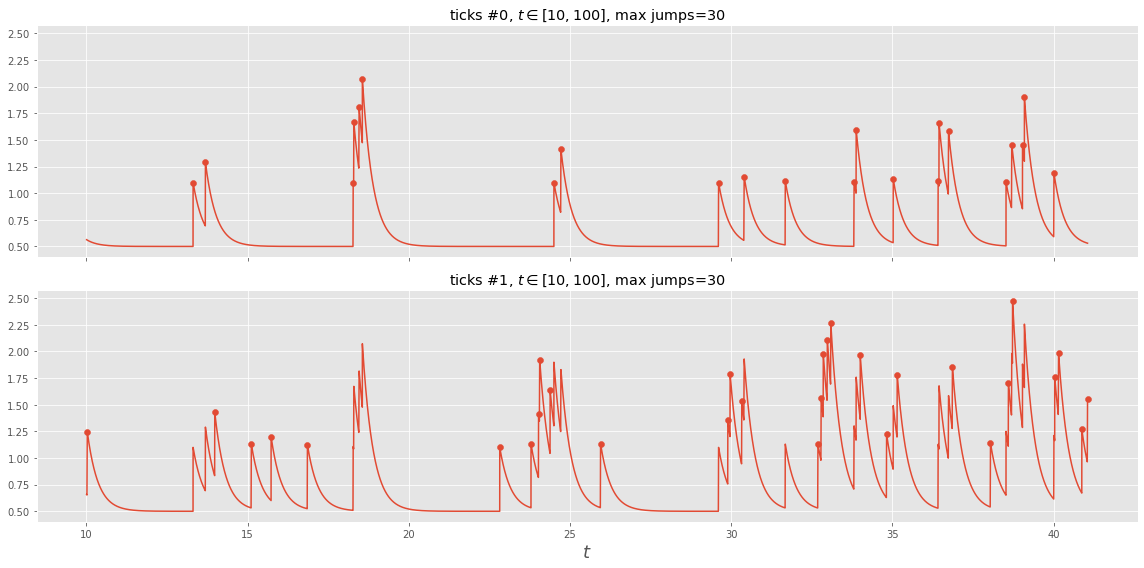

In [19]:
import matplotlib.pyplot as plt

from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

n_nodes = 2  # dimension of the Hawkes process
adjacency = 0.2 * np.ones((n_nodes, n_nodes))
adjacency[0, 1] = 0
decays = 3 * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)
hawkes = SimuHawkesExpKernels(adjacency=adjacency, decays=decays,
                              baseline=baseline, verbose=False, seed=2398)

run_time = 100
hawkes.end_time = run_time
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
fig.tight_layout()

In [21]:
events_ = hawkes.timestamps

In [22]:
decays_ = 2 * np.ones((n_nodes, n_nodes))
decays_hat = minimize(fun, x0=[decays_], method="Nelder-Mead", args=events_, tol=1e-05).x
# 

In [23]:
learner = get_HP_exp_learner(decays_hat, events_, verbose=True)

Launching the solver AGD...
  n_iter  |    obj    |    step   |  rel_obj 
       91 | -1.11e+00 |  4.34e-10 |  4.75e-11
Done solving using AGD in 0.0338292121887207 seconds
Adj: [[[0.         0.21706706 0.         0.        ]
  [0.0836065  0.         0.         0.        ]]

 [[0.         0.20869862 0.05309861 0.05057293]
  [0.         0.07735338 0.         0.        ]]], decays: [1.19401634 3.94339263 1.92775551 1.91103824], baselines: [0.58962227 0.66602582]


In [38]:
learner.score()

1.1092557631927749

In [25]:
residuals = goodness_of_fit_par(learner, events_, dt, integrate.simps)
# print(residuals)
# plot_resid(residuals)
# ks_test(residuals)

KstestResult(statistic=0.081482178609806, pvalue=0.6033962483993907)
KstestResult(statistic=0.0666696122429074, pvalue=0.7454743233700272)


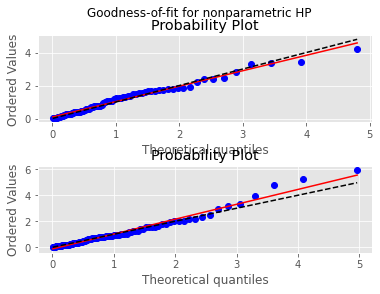

In [28]:
plot_resid(residuals, 2, 1)

In [32]:
ks_test(residuals)

[KstestResult(statistic=0.081482178609806, pvalue=0.6033962483993907),
 KstestResult(statistic=0.0666696122429074, pvalue=0.7454743233700272)]

In [35]:
lb_test(residuals)

[      lb_stat  lb_pvalue
 10  10.105351     0.4313,
       lb_stat  lb_pvalue
 10  10.195973   0.423472]

In [37]:
ed_test(residuals)

[-0.6104121409065334, 0.8196328670528805]